In [1]:
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.insert(0, src_path)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from statsmodels.tsa.seasonal import seasonal_decompose
from sales_forecast.config import config

In [2]:
TABLE_REF = f"{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}"

In [3]:
client = bigquery.Client(project=config.bq.PROJECT_ID, location="US")

# EDA - Pandas

In [4]:
# Query basic table info
query = f"""
SELECT *
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`;
"""
df = client.query(query).to_dataframe()
df['Date'] = pd.to_datetime(df['Date'])
print(f"Data shape: {df.shape}")
df.head()


/home/dev_thryvma/.cache/pypoetry/virtualenvs/sales-forecast-y1l5TSMz-py3.12/lib/python3.12/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


Data shape: (153, 19)


,Date,total,tavg,tmin,tmax,prcp,wspd,pres,is_holiday,holiday_name,is_school_break,dinner_impact_score,importance_score,is_evening,is_weekend,is_home,is_delhi,is_t20i,is_cricket_day
0,2024-09-01,27546,30.9,27.9,35.2,0.0,4.9,1003.5,0,No holiday,0,0.0,0.0,0,1,0,0,0,0
1,2024-09-02,17466,29.3,26.2,36.3,0.0,4.7,1003.8,0,No holiday,0,0.0,0.0,0,0,0,0,0,0
2,2024-09-03,20403,31.1,26.9,35.6,23.1,4.2,1003.8,0,No holiday,0,0.0,0.0,0,0,0,0,0,0
3,2024-09-04,31928,26.8,24.8,36.2,0.8,3.0,1002.9,0,No holiday,0,0.0,0.0,0,0,0,0,0,0
4,2024-09-05,15950,29.0,23.3,32.4,10.9,1.4,1001.0,0,No holiday,0,0.0,0.0,0,0,0,0,0,0


# Basic stats


In [5]:
print("Columns and types:\n", df.dtypes)
print("\nMissing values per column:\n", df.isna().sum())

Columns and types:
 Date                   datetime64[ns]
total                           Int64
tavg                          float64
tmin                          float64
tmax                          float64
prcp                          float64
wspd                          float64
pres                          float64
is_holiday                      Int64
holiday_name                   object
is_school_break                 Int64
dinner_impact_score           float64
importance_score              float64
is_evening                      Int64
is_weekend                      Int64
is_home                         Int64
is_delhi                        Int64
is_t20i                         Int64
is_cricket_day                  Int64
dtype: object

Missing values per column:
 Date                   0
total                  0
tavg                   0
tmin                   0
tmax                   0
prcp                   0
wspd                   0
pres                   0
is_holiday     

# Total row counts and date range

In [6]:
print("Row count:", len(df))
print("Date range:", df['Date'].min(), "to", df['Date'].max())
print("Number of weekends:", df['is_weekend'].sum())
print("Number of holidays:", df['is_holiday'].sum())
print("Number of school breaks:", df['is_school_break'].sum())
print("Number of cricket days:", df['is_cricket_day'].sum())
print("Number of rainy days:", df[df["prcp"]>1].shape[0])

Row count: 153
Date range: 2024-09-01 00:00:00 to 2025-01-31 00:00:00
Number of weekends: 43
Number of holidays: 8
Number of school breaks: 17
Number of cricket days: 61
Number of rainy days: 18


# Week-Sales Analysis

In [7]:
df['sales_week'] = df['Date'].dt.isocalendar().week

weekly_sales_df = df.groupby('sales_week')['total'].sum().reset_index()

weekly_sales_df.rename(columns={'total': 'weekly_sum'}, inplace=True)

weekly_sales_df.sort_values(by='weekly_sum', ascending=False, inplace=True)

print(weekly_sales_df)

    sales_week  weekly_sum
14          44      268197
17          47      260243
3            4      254296
15          45      252447
12          42      239507
16          46      238610
2            3      237784
0            1      235888
21          51      229953
13          43      225051
20          50      223256
18          48      215956
7           37      214406
19          49      208048
6           36      198392
1            2      194400
22          52      193965
9           39      184628
8           38      181811
11          41      175975
10          40      161314
4            5      134577
5           35       27546


# Monthly-Sales Analysis

In [8]:
df['sales_month'] = df['Date'].dt.month

monthly_sales_df = df.groupby('sales_month')['total'].sum().reset_index()

monthly_sales_df.rename(columns={'total': 'monthly_sum'}, inplace=True)

monthly_sales_df.sort_values(by='monthly_sum', ascending=False, inplace=True)

print(monthly_sales_df)

   sales_month  monthly_sum
3           11      1037246
0            1       980588
4           12       965167
2           10       949053
1            9       824196


# Daily-Sales Analysis

In [9]:
print("Sales Ordered by Date")
df[["Date", "total"]].sort_values(by="total", ascending=False)

Sales Ordered by Date


,Date,total
104,2024-12-14,70985
83,2024-11-23,69075
13,2024-09-14,64098
68,2024-11-08,63996
46,2024-10-17,59700
...,...,...
36,2024-10-07,14129
17,2024-09-18,11375
113,2024-12-23,9975
37,2024-10-08,8687


# Plot target over time


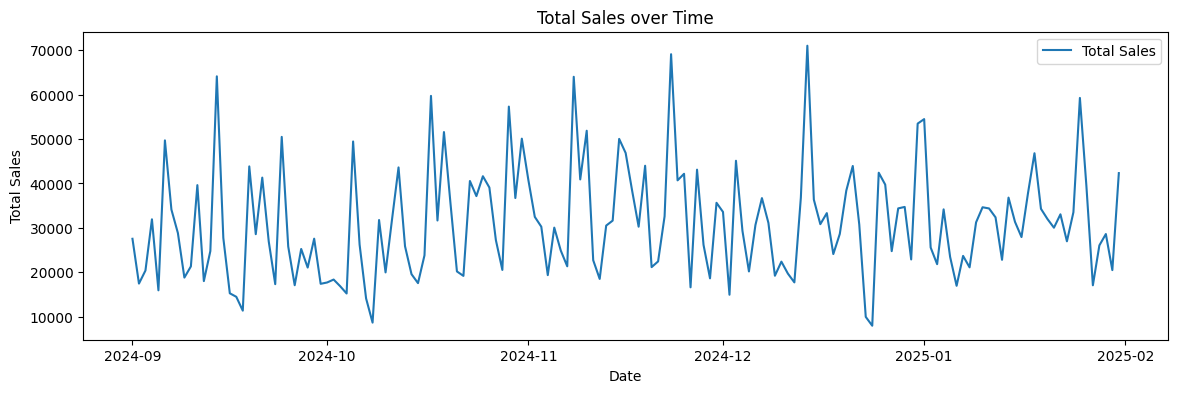

In [10]:
plt.figure(figsize=(14,4))
plt.plot(df['Date'], df['total'], label='Total Sales')
plt.title("Total Sales over Time")
plt.xlabel("Date")
plt.ylabel("Total Sales")
plt.legend()
plt.show()

# Trend decomposition

/tmp/ipykernel_5437/3997815612.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  ts = ts.fillna(method='ffill')


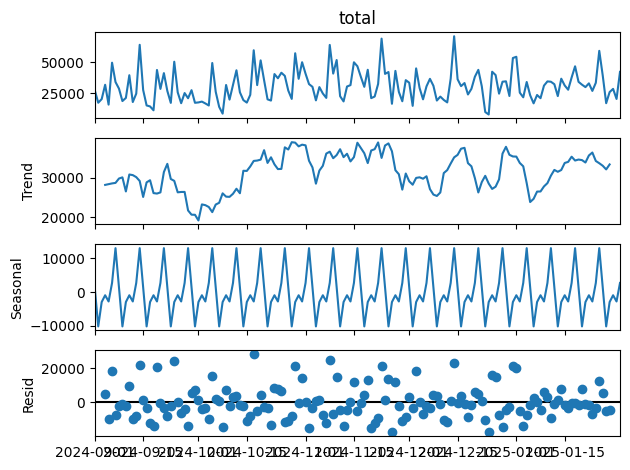

In [11]:
ts = df.set_index('Date')['total'].asfreq('D')  # daily frequency
ts = ts.fillna(method='ffill')
result = seasonal_decompose(ts, model='additive')
result.plot()
plt.show()

# Check distribution of target

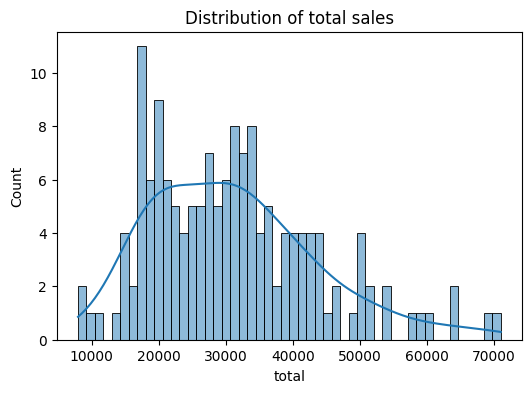

In [12]:
plt.figure(figsize=(6,4))
sns.histplot(df['total'], bins=50, kde=True)
plt.title("Distribution of total sales")
plt.show()

# Correlation heatmap for numerical columns

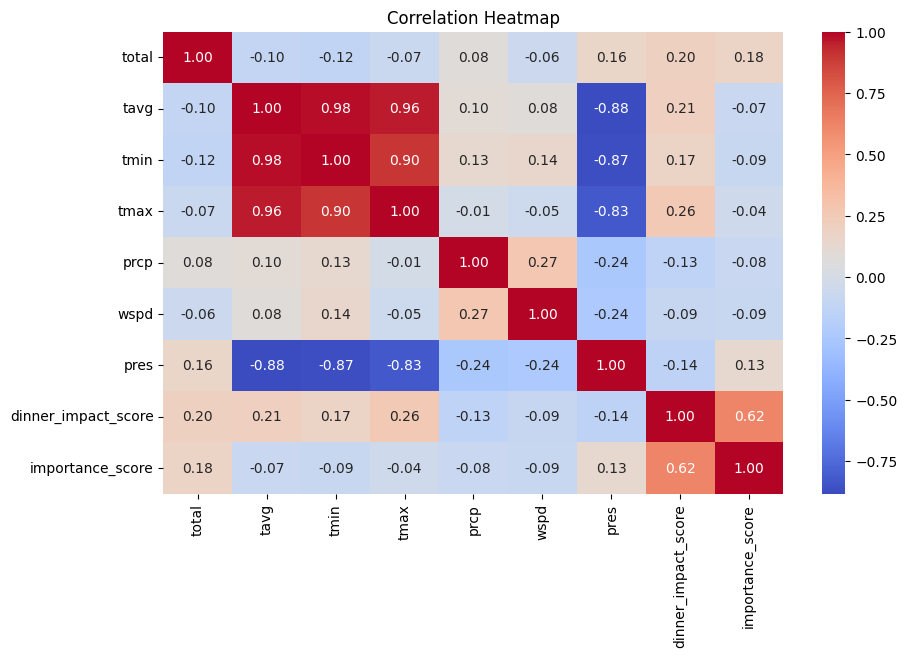

In [13]:
numerical_cols = ['total','tavg','tmin','tmax','prcp','wspd','pres','dinner_impact_score','importance_score']
plt.figure(figsize=(10,6))
sns.heatmap(df[numerical_cols].corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# Weekend, holiday, school break impact


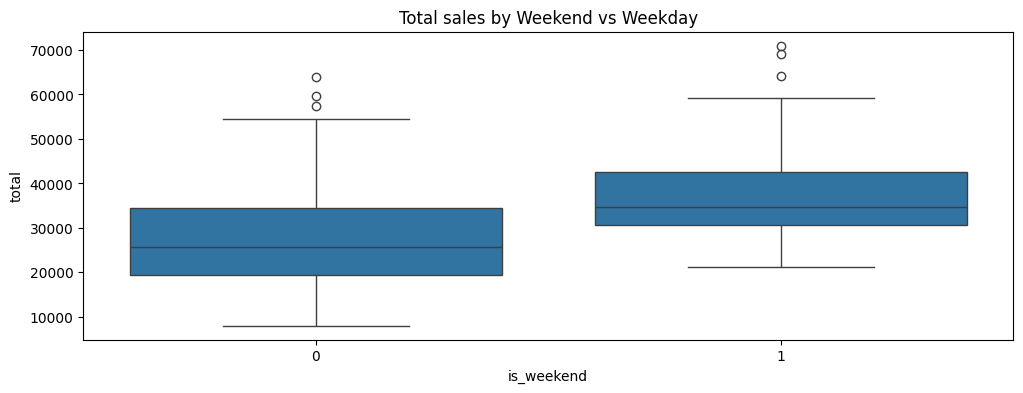

In [14]:
plt.figure(figsize=(12,4))
sns.boxplot(x='is_weekend', y='total', data=df)
plt.title("Total sales by Weekend vs Weekday")
plt.show()

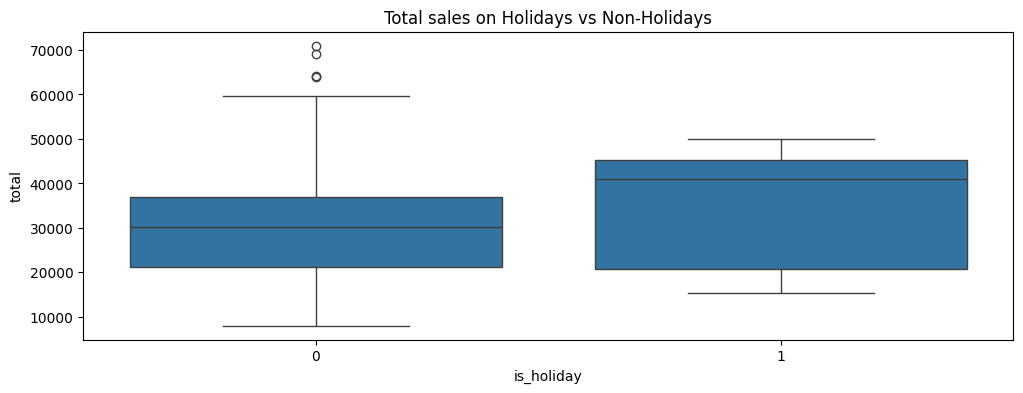

In [15]:
plt.figure(figsize=(12,4))
sns.boxplot(x='is_holiday', y='total', data=df)
plt.title("Total sales on Holidays vs Non-Holidays")
plt.show()

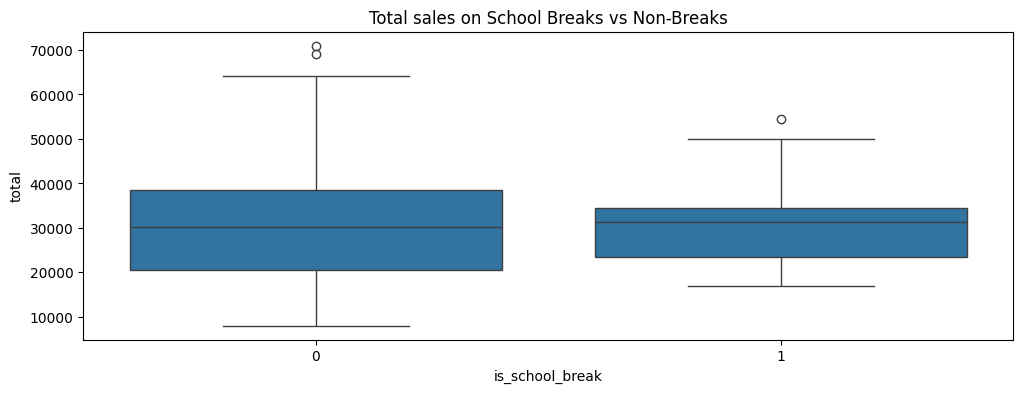

In [16]:
plt.figure(figsize=(12,4))
sns.boxplot(x='is_school_break', y='total', data=df)
plt.title("Total sales on School Breaks vs Non-Breaks")
plt.show()

# Dinner impact & importance score analysis


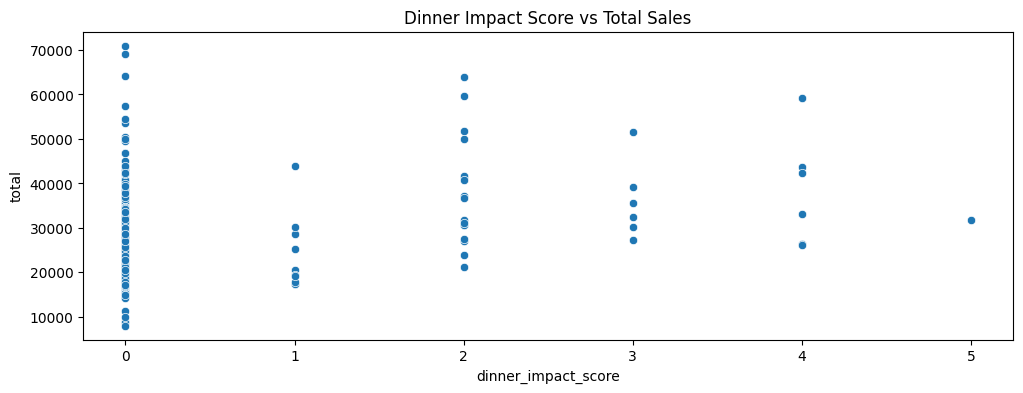

In [17]:
plt.figure(figsize=(12,4))
sns.scatterplot(x='dinner_impact_score', y='total', data=df)
plt.title("Dinner Impact Score vs Total Sales")
plt.show()

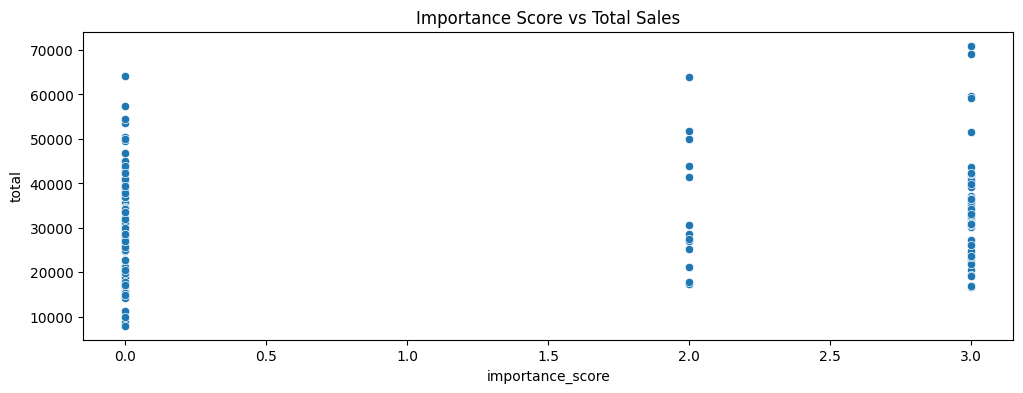

In [18]:
plt.figure(figsize=(12,4))
sns.scatterplot(x='importance_score', y='total', data=df)
plt.title("Importance Score vs Total Sales")
plt.show()

# Event flags (T20i, cricket day) effect


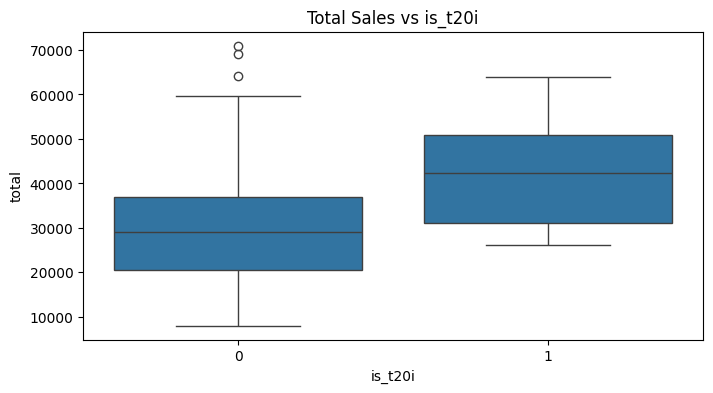

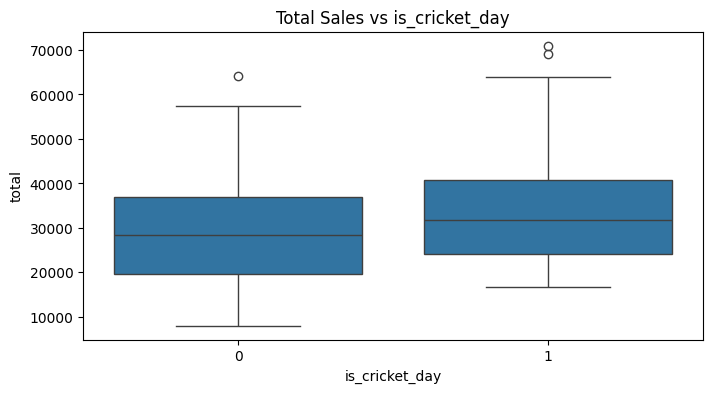

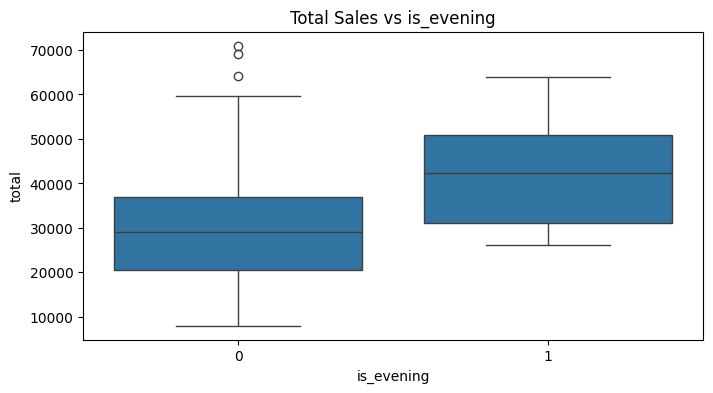

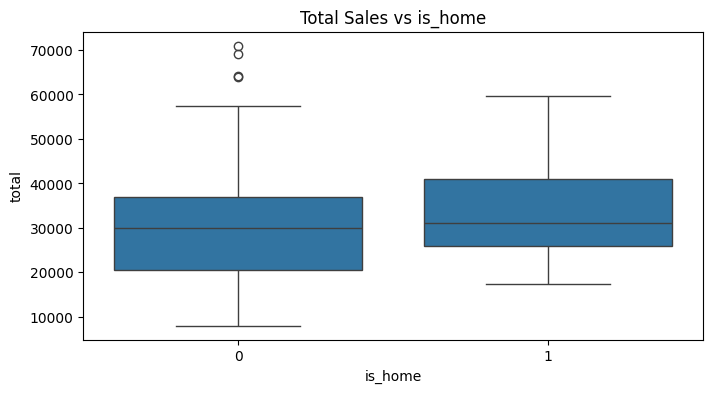

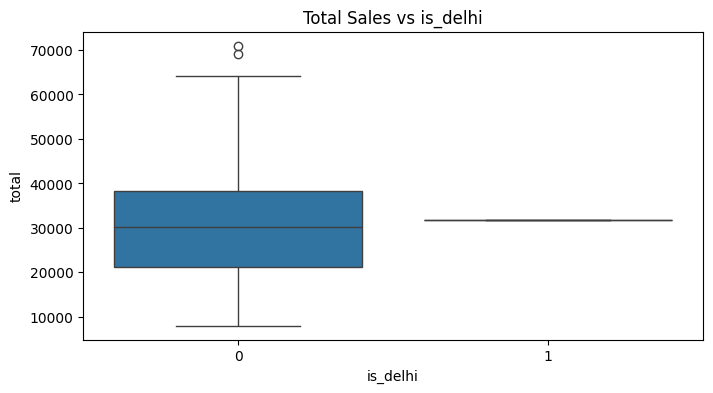

In [19]:
for col in ['is_t20i','is_cricket_day','is_evening','is_home','is_delhi']:
    plt.figure(figsize=(8,4))
    sns.boxplot(x=col, y='total', data=df)
    plt.title(f"Total Sales vs {col}")
    plt.show()

# Significance tests for boolean features

In [20]:
from scipy.stats import ttest_ind
import numpy as np
import pandas as pd

bool_cols = ['is_holiday', 'is_weekend', 'is_school_break',
             'is_evening', 'is_home', 'is_delhi',
             'is_t20i', 'is_cricket_day']

results = []

for col in bool_cols:
    group1 = df[df[col] == 1]['total']
    group0 = df[df[col] == 0]['total']

    # Welch’s t-test
    t_stat, p_value = ttest_ind(group1, group0, equal_var=False)

    # Effect size (Cohen’s d)
    d = (group1.mean() - group0.mean()) / np.sqrt((group1.var() + group0.var()) / 2)

    results.append({
        "feature": col,
        "mean_true": group1.mean(),
        "mean_false": group0.mean(),
        "difference": group1.mean() - group0.mean(),
        "p_value": p_value,
        "cohens_d": d
    })

test_results = pd.DataFrame(results)
test_results.sort_values("p_value", inplace=True)
test_results


,feature,mean_true,mean_false,difference,p_value,cohens_d
1,is_weekend,38155.860465,28323.163636,9832.696829,0.000012,0.840898
3,is_evening,41697.636364,30264.619718,11433.016645,0.017854,0.900544
6,is_t20i,41697.636364,30264.619718,11433.016645,0.017854,0.900544
7,is_cricket_day,33773.885246,29304.815217,4469.070029,0.032207,0.360053
4,is_home,32822.687500,30627.471074,2195.216426,0.344284,0.182334
0,is_holiday,35073.750000,30866.620690,4207.129310,0.442871,0.313114
2,is_school_break,30905.588235,31109.227941,-203.639706,0.942245,-0.017419
5,is_delhi,31768.000000,31082.118421,685.881579,NaN,<NA>


# SQL commands EDA

# Table Schema

In [21]:
table = client.get_table(TABLE_REF)
# Print the schema information
for field in table.schema:
    print(f"Column Name: {field.name:<20} Type: {field.field_type:<10} Mode: {field.mode:<10}")


Column Name: Date                 Type: DATE       Mode: NULLABLE  
Column Name: total                Type: INTEGER    Mode: NULLABLE  
Column Name: tavg                 Type: FLOAT      Mode: NULLABLE  
Column Name: tmin                 Type: FLOAT      Mode: NULLABLE  
Column Name: tmax                 Type: FLOAT      Mode: NULLABLE  
Column Name: prcp                 Type: FLOAT      Mode: NULLABLE  
Column Name: wspd                 Type: FLOAT      Mode: NULLABLE  
Column Name: pres                 Type: FLOAT      Mode: NULLABLE  
Column Name: is_holiday           Type: INTEGER    Mode: NULLABLE  
Column Name: holiday_name         Type: STRING     Mode: NULLABLE  
Column Name: is_school_break      Type: INTEGER    Mode: NULLABLE  
Column Name: dinner_impact_score  Type: FLOAT      Mode: NULLABLE  
Column Name: importance_score     Type: FLOAT      Mode: NULLABLE  
Column Name: is_evening           Type: INTEGER    Mode: NULLABLE  
Column Name: is_weekend           Type: INTEGER 

# Table Sample

In [22]:
query = f"""
SELECT *
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
LIMIT 10
"""
query_job = client.query(query)
results = query_job.result()

In [23]:
# Get column names for a header
columns = [field.name for field in results.schema]
print(f"Columns: {', '.join(columns)}")
print("-" * 50)

# Print the rows
for row in results:
    # row is a Row object, which can be treated like a tuple or dictionary
    print(row)

Columns: Date, total, tavg, tmin, tmax, prcp, wspd, pres, is_holiday, holiday_name, is_school_break, dinner_impact_score, importance_score, is_evening, is_weekend, is_home, is_delhi, is_t20i, is_cricket_day
--------------------------------------------------
Row((datetime.date(2024, 9, 1), 27546, 30.9, 27.9, 35.2, 0.0, 4.9, 1003.5, 0, 'No holiday', 0, 0.0, 0.0, 0, 1, 0, 0, 0, 0), {'Date': 0, 'total': 1, 'tavg': 2, 'tmin': 3, 'tmax': 4, 'prcp': 5, 'wspd': 6, 'pres': 7, 'is_holiday': 8, 'holiday_name': 9, 'is_school_break': 10, 'dinner_impact_score': 11, 'importance_score': 12, 'is_evening': 13, 'is_weekend': 14, 'is_home': 15, 'is_delhi': 16, 'is_t20i': 17, 'is_cricket_day': 18})
Row((datetime.date(2024, 9, 2), 17466, 29.3, 26.2, 36.3, 0.0, 4.7, 1003.8, 0, 'No holiday', 0, 0.0, 0.0, 0, 0, 0, 0, 0, 0), {'Date': 0, 'total': 1, 'tavg': 2, 'tmin': 3, 'tmax': 4, 'prcp': 5, 'wspd': 6, 'pres': 7, 'is_holiday': 8, 'holiday_name': 9, 'is_school_break': 10, 'dinner_impact_score': 11, 'importance_s

# Number of Rows

In [24]:
query = f"""
SELECT COUNT(Date) as total_count
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [25]:
for row in results:
    # Access the result by the column name 'total_count'
    num_of_rows = row["total_count"]
    print(f"The number of rows is: {num_of_rows}")

The number of rows is: 153


# Min / Max dates

In [26]:
query = f"""
SELECT MIN(Date) as min_date, MAX(Date) as max_date
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [27]:
for row in results:
    # Access the result by the column name 'total_count'
    min_date = row["min_date"]
    max_date = row["max_date"]
    print(f"The min date of the table: {min_date}")
    print(f"The max date of the table: {max_date}")

The min date of the table: 2024-09-01
The max date of the table: 2025-01-31


# Missing value counts

In [28]:
table = client.get_table(TABLE_REF)
count_expressions = []
for field in table.schema:
    count_expression = f"COUNTIF({field.name} IS NULL) as nulls_{field.name}"
    count_expressions.append(count_expression)

select_clause = ",\n".join(count_expressions)

query = f"""
SELECT
{select_clause}
FROM `{TABLE_REF}`
"""
query_job = client.query(query)
results = query_job.result()

In [29]:
for row in results:
    print("\n--- NULL Counts per Column ---")
    for column_name, null_count in row.items():
        original_col_name = column_name.replace("nulls_", "")
        print(f"Column: {original_col_name:<30} NULL Count: {null_count}")


--- NULL Counts per Column ---
Column: Date                           NULL Count: 0
Column: total                          NULL Count: 0
Column: tavg                           NULL Count: 0
Column: tmin                           NULL Count: 0
Column: tmax                           NULL Count: 0
Column: prcp                           NULL Count: 0
Column: wspd                           NULL Count: 0
Column: pres                           NULL Count: 0
Column: is_holiday                     NULL Count: 0
Column: holiday_name                   NULL Count: 0
Column: is_school_break                NULL Count: 0
Column: dinner_impact_score            NULL Count: 0
Column: importance_score               NULL Count: 0
Column: is_evening                     NULL Count: 0
Column: is_weekend                     NULL Count: 0
Column: is_home                        NULL Count: 0
Column: is_delhi                       NULL Count: 0
Column: is_t20i                        NULL Count: 0
Column: is_cri

# Week-Sales Analysis

In [38]:
query = f"""
SELECT EXTRACT(WEEK FROM Date) AS sales_week, SUM(total) AS weekly_sum
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
GROUP BY sales_week
ORDER BY weekly_sum desc;
"""
query_job = client.query(query)
results = query_job.result()

In [39]:
for row in results:
    week_number = row["sales_week"]
    total_sales = row["weekly_sum"]
    print(f"{week_number:<10} | {total_sales}")

43         | 265187
46         | 257903
45         | 252114
3          | 249114
2          | 235863
50         | 235566
42         | 233407
44         | 230856
41         | 229765
47         | 223061
49         | 218018
36         | 215500
48         | 210518
35         | 197105
51         | 189995
1          | 185502
38         | 183993
37         | 182611
40         | 176350
4          | 174049
39         | 162643
0          | 136060
52         | 111070


# Month-Sales Analysis

In [40]:
query = f"""
SELECT EXTRACT(MONTH FROM Date) AS sales_month, SUM(total) AS montly_sum
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
GROUP BY sales_month
ORDER BY montly_sum desc;
"""
query_job = client.query(query)
results = query_job.result()

In [41]:
for row in results:
    month_number = row["sales_month"]
    total_sales = row["montly_sum"]
    print(f"{month_number:<10} | {total_sales}")

11         | 1037246
1          | 980588
12         | 965167
10         | 949053
9          | 824196


# Daily-Sales Analysis

In [42]:
query = f"""
SELECT Date, Total
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
ORDER BY Total desc
LIMIT 10;
"""
query_job = client.query(query)
results = query_job.result()

In [43]:
for row in results:
    date = row["Date"]
    total = row["Total"]
    print(f"The date is: {date}")
    print(f"The sales are: {total}")

The date is: 2024-12-14
The sales are: 70985
The date is: 2024-11-23
The sales are: 69075
The date is: 2024-09-14
The sales are: 64098
The date is: 2024-11-08
The sales are: 63996
The date is: 2024-10-17
The sales are: 59700
The date is: 2025-01-25
The sales are: 59239
The date is: 2024-10-29
The sales are: 57289
The date is: 2025-01-01
The sales are: 54473
The date is: 2024-12-31
The sales are: 53460
The date is: 2024-11-10
The sales are: 51857


# Holiday-Sales analysis

In [44]:
query = f"""
SELECT is_holiday, AVG(total)
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
GROUP BY is_holiday;
"""
query_job = client.query(query)
results = query_job.result()

In [45]:
for row in results:
    print(row)

Row((0, 30866.62068965517), {'is_holiday': 0, 'f0_': 1})
Row((1, 35073.75), {'is_holiday': 0, 'f0_': 1})


# Correlations

In [46]:
query = f"""
SELECT CORR(total, tavg) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [47]:
for row in results:
    print(row)

Row((-0.10438931796176215,), {'f0_': 0})


In [48]:
query = f"""
SELECT CORR(total, tmin) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [49]:
for row in results:
    print(row)

Row((-0.12170239075513443,), {'f0_': 0})


In [50]:
query = f"""
SELECT CORR(total, tmax) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [51]:
for row in results:
    print(row)

Row((-0.06782637253638633,), {'f0_': 0})


In [52]:
query = f"""
SELECT CORR(total, prcp) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [53]:
for row in results:
    print(row)

Row((0.07648507356452663,), {'f0_': 0})


In [54]:
query = f"""
SELECT CORR(total, wspd) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [55]:
for row in results:
    print(row)

Row((-0.06423559831119435,), {'f0_': 0})


In [56]:
query = f"""
SELECT CORR(total, pres) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [57]:
for row in results:
    print(row)

Row((0.155408206390888,), {'f0_': 0})


In [58]:
query = f"""
SELECT CORR(total, is_school_break) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [59]:
for row in results:
    print(row)

Row((-0.0051434295837628815,), {'f0_': 0})


In [60]:
query = f"""
SELECT CORR(total, dinner_impact_score) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [61]:
for row in results:
    print(row)

Row((0.1995849772059825,), {'f0_': 0})


In [62]:
query = f"""
SELECT CORR(total, importance_score) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [63]:
for row in results:
    print(row)

Row((0.17616543110969948,), {'f0_': 0})


In [64]:
query = f"""
SELECT CORR(total, is_evening) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [65]:
for row in results:
    print(row)

Row((0.23735466567716362,), {'f0_': 0})


In [66]:
query = f"""
SELECT CORR(total, is_weekend) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [67]:
for row in results:
    print(row)

Row((0.35522182538163893,), {'f0_': 0})


In [68]:
query = f"""
SELECT CORR(total, is_home) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [69]:
for row in results:
    print(row)

Row((0.07175322746734067,), {'f0_': 0})


In [70]:
query = f"""
SELECT CORR(total, is_delhi) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [71]:
for row in results:
    print(row)

Row((0.004441885459475335,), {'f0_': 0})


In [72]:
query = f"""
SELECT CORR(total, is_t20i) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [73]:
for row in results:
    print(row)

Row((0.23735466567716362,), {'f0_': 0})


In [74]:
query = f"""
SELECT CORR(total, is_cricket_day) 
FROM `{config.bq.PROJECT_ID}.{config.bq.DATASET}.{config.bq.FINAL_TABLE}`
"""
query_job = client.query(query)
results = query_job.result()

In [75]:
for row in results:
    print(row)

Row((0.17586216429474824,), {'f0_': 0})
